### Counting number of cells - Computer Vision 2023

This code is used to count the number of cells of a video of cells in microdroplets. Then using background subtraction algorithms and other algorithms to count the cells in each droplet.

Notes for use:
Video should be provided in .tif format
The ouput gives an image of the background/foreground mask as well as the count of cells in each droplet.

Created by Turlagh Clancy - 18/10/2023

Update log:

In [3]:
# Base code
#1. Upload the tif file - done
#2. do background subtraction algorithm (as a function) - done
#3. Visualise background subtraction algorithm  - done

#Improvements
#4. Find better background frame to initialise - done
#5. find better way to update background 
#6. Find a better background subtraction method, compare computation times, discuss quantitative assesments

#Later part 2.2
#7. import cell counts and boxes - 
#8. use algorithm to count cells in each box - have multiple methods
#9. Work on other counting methods, and compare them

In [4]:
#import libraries

import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import os

import matplotlib.animation as mat_anim
from IPython.display import HTML

In [5]:
# Function to present the Original and BGS frames side by side for visualisation. Created by Benoit Lu and given permission to use here on 18/10/2023
def draw_frames(frames, bgs_frames):
    if len(frames) != len(bgs_frames):
        raise Exception("The number of frames on each array doesn't match.")
    fig, axs = plt.subplots(1, 2, figsize=(12,4))
    plt.tight_layout()

    def update(frame):
        plt.suptitle(f"Frame {frame}")
        axs[0].clear() 
        axs[1].clear()  
        axs[0].set_title("Original")
        axs[0].imshow(frames[frame], cmap='gray')  
        axs[1].set_title("BGS")
        axs[1].imshow(bgs_frames[frame], cmap='gray') 
        return axs

    return mat_anim.FuncAnimation(fig=fig, func=update, frames=len(frames), interval=500)

def convert_to_grayscale(rgb_image):
    return np.dot(rgb_image[...,:3], [0.2989, 0.5870, 0.1140])

def process_TIF(filepath): # Function to get from tif file to grayscale image, maybe should change imread to only get grayscale
    #tif file to RGB numpy array
    array = tiff.imread(filepath)
    #convert to greyscale
    gray_arr = convert_to_grayscale(array)
    return gray_arr


In [44]:
def crop_frame(frame, target_height):
    return frame[:target_height, :]

def CreateBaseBackgroundImage(folderpath, outputfile = 'output.tif'):
    tif_files = [file for file in os.listdir(folderpath) if file.endswith(".tif")]

    first_file = os.path.join(folderpath, tif_files[0])
    background = crop_frame(tiff.imread(first_file)[0], target_height=1100)

    total_frames = 1

    for tif_file in tif_files:
        file_path = os.path.join(folderpath, tif_file)
        frames = tiff.imread(file_path)
        frames = np.array([crop_frame(frame, target_height=1100) for frame in frames])
        background = (background * total_frames + np.sum(frames, axis=0)) / (total_frames + len(frames))
        total_frames += len(frames)

    backgroundImageGrey = convert_to_grayscale(background).astype(np.uint8)
    tiff.imsave(outputfile, backgroundImageGrey)

    return backgroundImageGrey

In [95]:
def simple_background_subtraction(frames, threshold=30, learning_rate = 0.05, background_init = None):
    # Function to apply our background subtraction algorithm
    #   frames is a numpy array with dimensions (num_frames, width, height)
    #   threshold is a parameter that determines how close or far the pixel values have to differ form the background to be considered foreground
    #   learning rate is another parameter about how quickly we adapt the background frame based off new data, useful if the overall image gets brighter/darker over the video
    #   Background Init should be a numpy array of the background frame
    
    # Initialise array for the foreground
    num_frames, width, height = frames.shape
    grayscale_masks = np.zeros((num_frames, width, height), dtype=np.uint8)

    # Either choose the initalise background path, or replace it with the average value of the frame
    if background_init is not None:
        if background_init.shape == (width, height):
            background_frame = background_init
        else:
            raise ValueError("The dimensions of the external background image do not match the input frames.")
    else:
        background_frame = frames[0]

    # Loop through each frame and compare it to the background frame
    for frame_num in range(0, num_frames):
        current_frame = frames[frame_num]

        # Calculate the difference between frame and background
        frame_diff = np.abs(current_frame - background_frame)
        grayscale_mask = (frame_diff > threshold).astype(np.uint8) * 255

        # Update the background frame 
        background_frame = background_frame * (1- learning_rate) + current_frame * learning_rate # exponential learning rate to quickly find background and then eliminate ghosting

        # Store the inverted grayscale mask in the result (foreground is black, background is white)
        grayscale_masks[frame_num] = grayscale_mask

    return grayscale_masks

In [14]:
# Load data - takes roughly 50sec
seq41 = process_TIF("4-1.tif")
seq41 = seq41[:20]

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


Background initalisation: Local background file exists, will load it


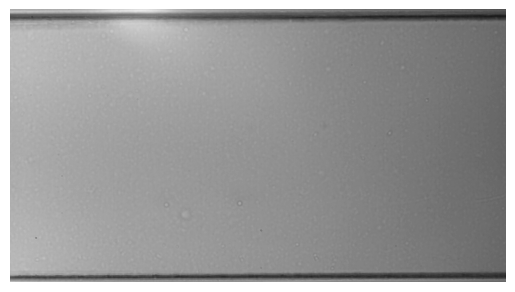

In [90]:

input_folder = r"C:\Users\turla\Documents\4. Uliege\Semester 3\Computer Vision\Project\Part 2\All Sequences"
output_file = r"background_init.tif"

if os.path.exists(output_file):
    backgroundImage = convert_to_grayscale(tiff.imread(output_file))
    print("Background initalisation: Local background file exists, will load it")
else: 
    backgroundImage = CreateBaseBackgroundImage(input_folder, output_file)
    print("Background initalisation: Background file does not exist, will generate it")

plt.imshow(backgroundImage, cmap='gray', vmin=0, vmax=255)
plt.axis('off')  # Turn off the axes
plt.show()

In [100]:
%%time
#perform background subtraction and time it
bgs41 = simple_background_subtraction(seq41, threshold= 10, learning_rate= 0.1, background_init= backgroundImage)

CPU times: total: 281 ms
Wall time: 788 ms


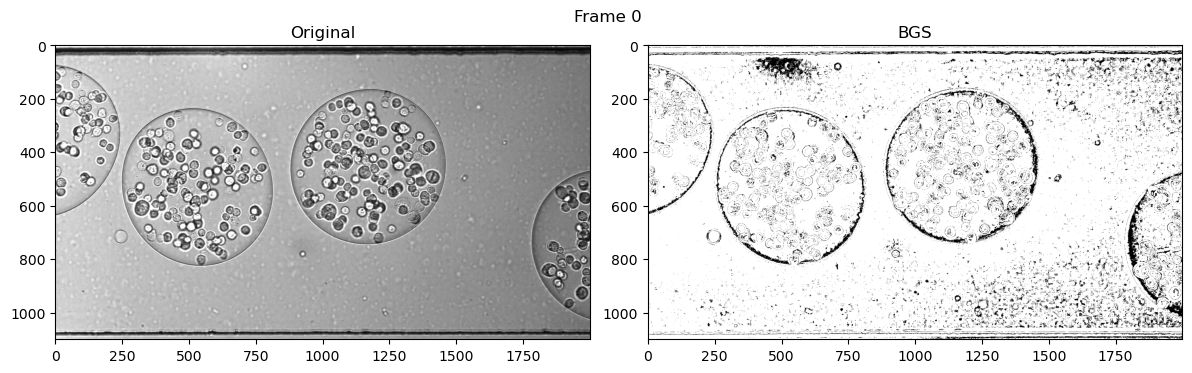

In [101]:
# Display the original side by side with the foreground masks
animation = draw_frames(seq41[:20], bgs41[:20])
HTML(animation.to_html5_video())